This program runs ride sharing algorithm for entire year.The following cell is run for 2015 data.The distances between trip pickup and dropoff have been calculated in prior and saved in csv format which is loaded into this program before calling the algorithm.
The program then plots average distance and average trip saved for different pool window.

In [2]:
import seaborn as sns
import main as rsg
import pandas as pd
from h3 import h3
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import requests,json ,math,time
from urllib.request import URLError, Request, urlopen
from itertools import combinations 
from datetime import datetime, timedelta,parser
import networkx as nx
home = "/home/shet/Documents/CS_RideSharing/"

In [38]:
sns.set(style="whitegrid")
def ceil_dt(dt, delta):
        return datetime.min + math.ceil((dt - datetime.min) / delta) * delta
def plot_bar(df_results,label,result_type):
    a4_dims = (12, 9)
    sns.set(rc={'figure.figsize':(13,9)})
    ax = sns.barplot(x="trip_type", y=result_type, hue="pool_windows", data=df_results,palette="Blues_d")
    ax.set_xlabel('')
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width()/2., 1*height,
                    '{}%'.format(round(height,2)),
                    ha='center', va='bottom')
    for ticks in ax.xaxis.get_major_ticks():
        ticks.label.set_fontsize(18)
    ax.set_ylabel('Average {} saved'.format(label),fontsize = 18)
    ax.set_title('Average {} for the year 2015'.format(label),fontsize = 18)
    plt.show()

### The following code takes several hours (took approximately 2 days for pool window 2,5) for both the trip types ie From Lga and To Lga.

In [ ]:
month_dic = {'Jan':'1','Feb':'2','Mar':'3','Apr':'4','May':'5','June':'6','July':'7','Aug':'8',\
            'Sep':'9','Oct':'10','Nov':'11','Dec':'12'}
results = dict()
distance_saved_montly = dict()
trip_saved_montly = dict()
pool_windows = [2,5]
for pool_time_window in pool_windows:
    for folder in [("Data/LGA as pickup/LaGuardia_as_pickup_2015-","Distance/LGA_as_pickup/2015-",1),\:
                  ("/Data/LGA as dropoff/LaGuardia_as_dropoff_2015-","Distance/LGA_drop_off/2015-",2)]:
        if 'pickup' in folder[0]:
            resolution = (15,15)
            trip_type = 'From LGA'
        else:
            resolution = (10,8)
            trip_type = 'To LGA'
            
        #initialization
        total_distance_saved = [0,0]
        total_trip_saved = [0,0]
        results[pool_time_window] = []
        
        for month in ("Jan",'Feb','Mar','Apr','May','June','July','Aug','Sep','Oct','Nov','Dec'):
            distance_saved_montly[folder[0].split('/')[-1][:-1]+'_'+str(pool_time_window)+'_'+str(month)] = []
            data_file = home+folder[0]+month+'.csv'
            distance_file_name = home+folder[1]+month_dic[month]+'.csv'
            print("--------------------------------------------------------------")
            print("Using data file {}".format(data_file))
            print("Using distance file {}".format(distance_file_name))
            df = pd.read_csv(data_file)
            df_distance = pd.read_csv(distance_file_name)

            df_distance.drop_duplicates(subset=['pickup_h3','dropoff_h3'],keep=False,inplace=True)
            df_distance.set_index(['pickup_h3','dropoff_h3'],inplace= True)
            df_distance = df_distance.sort_index()

            columns = ['tpep_pickup_datetime', 'tpep_dropoff_datetime','passenger_count',\
           'trip_distance', 'pickup_longitude','pickup_latitude','dropoff_longitude', 'dropoff_latitude']
            df = df[columns]
            df.rename(columns={'tpep_pickup_datetime':'pickup_time','tpep_dropoff_datetime':'dropoff_time'},inplace=True)
            drop_index=df[(df.pickup_latitude==0)|(df.pickup_longitude==0)|(df.trip_distance==0)].index
            df.drop(drop_index,inplace=True)
            df['pickup_time'] = pd.to_datetime(df['pickup_time'])
            df['dropoff_time'] = pd.to_datetime(df['dropoff_time'])
            df['pickup_h3'] = df.apply(lambda x: h3.geo_to_h3(x['pickup_latitude'], x['pickup_longitude'], resolution[0]), axis=1)
            df['dropoff_h3'] = df.apply(lambda x: h3.geo_to_h3(x['dropoff_latitude'], x['dropoff_longitude'], resolution[1]), axis=1)

            df.reset_index(drop=True,inplace=True)
            df['duration'] = (df['pickup_time']-df['dropoff_time']).dt.seconds
            df['delay'] = df['duration'].apply(lambda x: x*0.20)

            df['pool_window'] = df['pickup_time'].apply(lambda x: ceil_dt(x.to_pydatetime(), timedelta(minutes=pool_time_window)))
            print("starting for {} month....".format(month))
            distance_saved_num,distance_saved_deno,trip_saved_num,trip_saved_deno = rsg.main_algoritm(folder[2],df,df_distance)
            del df ,df_distance
            total_distance_saved[0]+= distance_saved_num
            total_distance_saved[1]+= distance_saved_deno*100
            total_trip_saved[0]+= trip_saved_num
            total_trip_saved[1]+= trip_saved_deno
            
        #aggregrate 12 month results and save it into results   
        distance_saved = (total_distance_saved[0]/total_distance_saved[1])*100
        trip_saved = (total_trip_saved[0]/total_trip_saved[1])*100
        results[pool_time_window].extend((distance_saved,trip_saved,trip_type))
        print("Average distance saved for {}  for pool window {} = {}".format(folder[0].split('/')[-1][:-1],pool_time_window,distance_saved))
        print("Average trip saved for {} for pool window {} = {}".format(folder[0].split('/')[-1][:-1],pool_time_window,trip_saved))
df_results = pd.DataFrame(columns= ['pool_windows','distance_saved','trip_saved','trip_type'])
for i,v in results.items():
    df_results = pd.Series([i]+v, index=df_results.columns )
    df_results = df_results.append(df1, ignore_index=True)

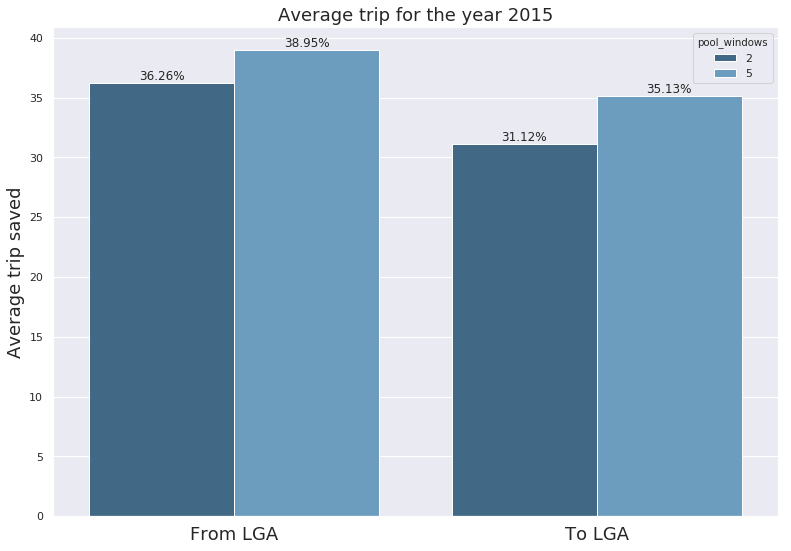

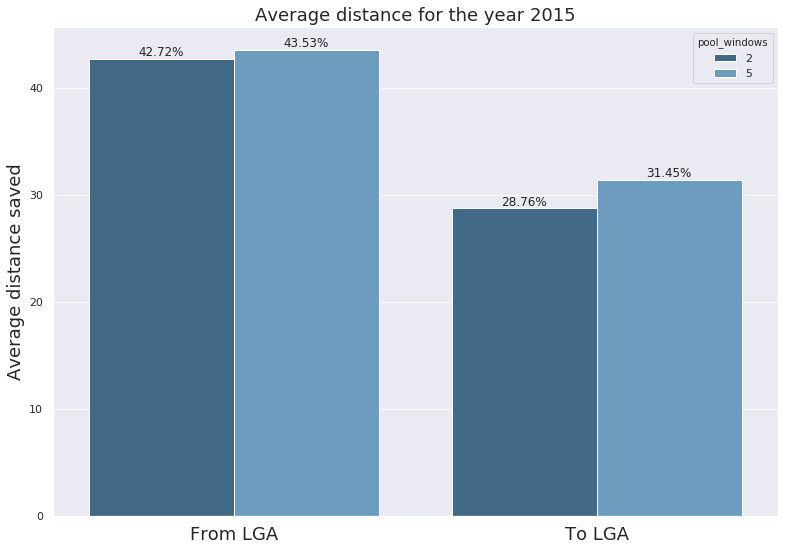

In [46]:
plot_bar(df_results,"trip","trip_saved")
plot_bar(df_results,"distance","distance_saved")